In [18]:
%matplotlib inline
from yahoo_finance import Share
from matplotlib import pyplot as plt
import numpy as np
import random
import tensorflow as tf
import random

tf.compat.v1.disable_eager_execution()

In [3]:
class DecisionPolicy:
    def select_action(self, current_state, step):
        pass

    def update_q(self, state, action, reward, next_state):
        pass

In [4]:
class RandomDecisionPolicy(DecisionPolicy):
    def __init__(self, actions):
        self.actions = actions

    def select_action(self, current_state, step):
        action = random.choice(self.actions)
        return action

In [26]:
class QLearningDecisionPolicy(DecisionPolicy):
    def __init__(self, actions, input_dim):
        self.epsilon = 0.95
        self.gamma = 0.3
        self.actions = actions
        output_dim = len(actions)
        h1_dim = 20

        self.x = tf.compat.v1.placeholder(tf.float32, [None, input_dim])
        self.y = tf.compat.v1.placeholder(tf.float32, [output_dim])
        W1 = tf.Variable(tf.compat.v1.random_normal([input_dim, h1_dim]))
        b1 = tf.Variable(tf.constant(0.1, shape=[h1_dim]))
        h1 = tf.nn.relu(tf.matmul(self.x, W1) + b1)
        W2 = tf.Variable(tf.compat.v1.random_normal([h1_dim, output_dim]))
        b2 = tf.Variable(tf.constant(0.1, shape=[output_dim]))
        self.q = tf.nn.relu(tf.matmul(h1, W2) + b2)

        loss = tf.square(self.y - self.q)
        self.train_op = tf.compat.v1.train.AdamOptimizer(0.001).minimize(loss)
        self.sess = tf.compat.v1.Session()
        self.sess.run(tf.compat.v1.global_variables_initializer())

    def select_action(self, current_state, step):
        threshold = min(self.epsilon, step / 1000.)
        if random.random() < threshold:
            # Exploit best option with probability epsilon
            action_q_vals = self.sess.run(self.q, feed_dict={self.x: current_state})
            action_idx = np.argmax(action_q_vals)  # TODO: replace w/ tensorflow's argmax
            action = self.actions[action_idx]
        else:
            # Explore random option with probability 1 - epsilon
            action = self.actions[random.randint(0, len(self.actions) - 1)]
        return action

    def update_q(self, state, action, reward, next_state):
        action_q_vals = self.sess.run(self.q, feed_dict={self.x: state})
        next_action_q_vals = self.sess.run(self.q, feed_dict={self.x: next_state})
        next_action_idx = np.argmax(next_action_q_vals)
        current_action_idx = self.actions.index(action)
        action_q_vals[0, current_action_idx] = reward + self.gamma * next_action_q_vals[0, next_action_idx]
        action_q_vals = np.squeeze(np.asarray(action_q_vals))
        self.sess.run(self.train_op, feed_dict={self.x: state, self.y: action_q_vals})

In [13]:
def run_simulation(policy, initial_budget, initial_num_stocks, prices, hist, debug=False):
    budget = initial_budget
    num_stocks = initial_num_stocks
    share_value = 0
    transitions = list()
    for i in range(len(prices) - hist - 1):
        if i % 1000 == 0:
            print('progress {:.2f}%'.format(float(100*i) / (len(prices) - hist - 1)))
        current_state = np.asmatrix(np.hstack((prices[i:i+hist], budget, num_stocks)))
        current_portfolio = budget + num_stocks * share_value
        action = policy.select_action(current_state, i)
        share_value = float(prices[i + hist])
        if action == 'Buy' and budget >= share_value:
            budget -= share_value
            num_stocks += 1
        elif action == 'Sell' and num_stocks > 0:
            budget += share_value
            num_stocks -= 1
        else:
            action = 'Hold'
        new_portfolio = budget + num_stocks * share_value
        reward = new_portfolio - current_portfolio
        next_state = np.asmatrix(np.hstack((prices[i+1:i+hist+1], budget, num_stocks)))
        transitions.append((current_state, action, reward, next_state))
        policy.update_q(current_state, action, reward, next_state)

    portfolio = budget + num_stocks * share_value
    if debug:
        print('${}\t{} shares'.format(budget, num_stocks))
    return portfolio

In [14]:
def run_simulations(policy, budget, num_stocks, prices, hist):
    num_tries = 5
    final_portfolios = list()
    for i in range(num_tries):
        print('Running simulation {}...'.format(i + 1))
        final_portfolio = run_simulation(policy, budget, num_stocks, prices, hist)
        final_portfolios.append(final_portfolio)
        print('Final portfolio: ${}'.format(final_portfolio))
    plt.title('Final Portfolio Value')
    plt.xlabel('Simulation #')
    plt.ylabel('Net worth')
    plt.plot(final_portfolios)
    plt.show()

In [15]:
def get_prices(share_symbol, start_date, end_date, cache_filename='stock_prices.npy'):
    try:
        stock_prices = np.load(cache_filename)
    except IOError:
        share = Share(share_symbol)
        stock_hist = share.get_historical(start_date, end_date)
        stock_prices = [stock_price['Open'] for stock_price in stock_hist]
        np.save(cache_filename, stock_prices)

    return stock_prices.astype(float)

In [16]:
def plot_prices(prices):
    plt.title('Opening stock prices')
    plt.xlabel('day')
    plt.ylabel('price ($)')
    plt.plot(prices)
    plt.savefig('prices.png')
    plt.show()

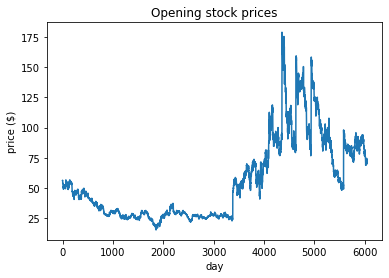

Running simulation 1...
progress 0.00%
progress 16.55%
progress 33.10%
progress 49.64%
progress 66.19%
progress 82.74%
progress 99.29%
Final portfolio: $218751.354989
Running simulation 2...
progress 0.00%
progress 16.55%
progress 33.10%
progress 49.64%
progress 66.19%
progress 82.74%
progress 99.29%
Final portfolio: $217383.3149910001
Running simulation 3...
progress 0.00%
progress 16.55%
progress 33.10%
progress 49.64%
progress 66.19%
progress 82.74%
progress 99.29%
Final portfolio: $217783.50498600025
Running simulation 4...
progress 0.00%
progress 16.55%
progress 33.10%
progress 49.64%
progress 66.19%
progress 82.74%
progress 99.29%
Final portfolio: $219254.58508000022
Running simulation 5...
progress 0.00%
progress 16.55%
progress 33.10%
progress 49.64%
progress 66.19%
progress 82.74%
progress 99.29%
Final portfolio: $218764.7949970001


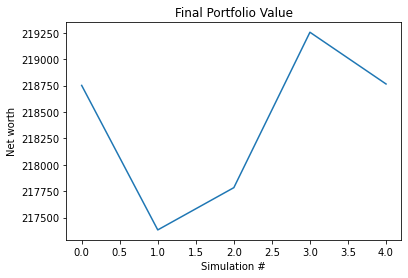

In [27]:
if __name__ == '__main__':
    prices = get_prices('MSFT', '1992-07-22', '2016-07-22')
    plot_prices(prices)
    actions = ['Buy', 'Sell', 'Hold']
    hist = 3
    # policy = RandomDecisionPolicy(actions)
    policy = QLearningDecisionPolicy(actions, hist + 2)
    budget = 100000.0
    num_stocks = 0
    run_simulations(policy, budget, num_stocks, prices, hist)